### Import libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Get images.

In [2]:
import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)
data_dir = pathlib.Path("dummy_images") # Replace dummy_images with images.

In [3]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

3952


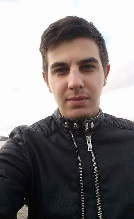

In [4]:
CleanSkinPix = list(data_dir.glob('CleanSkin/*'))
imt = im.open(str(CleanSkinPix[10]))
display(imt.resize((int(imt.size[0]/4),int(imt.size[1]/4)), 0))

### Split the dataset into training and validation.

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3952 files belonging to 9 classes.
Using 3162 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3952 files belonging to 9 classes.
Using 790 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Chlamydial', 'CleanSkin', 'GHerpes', 'Gonococcal', 'NonHIV', 'OtherSkin', 'OtherSti', 'Syphilis', 'Trichomoniasis']


### Visualize sample training images.

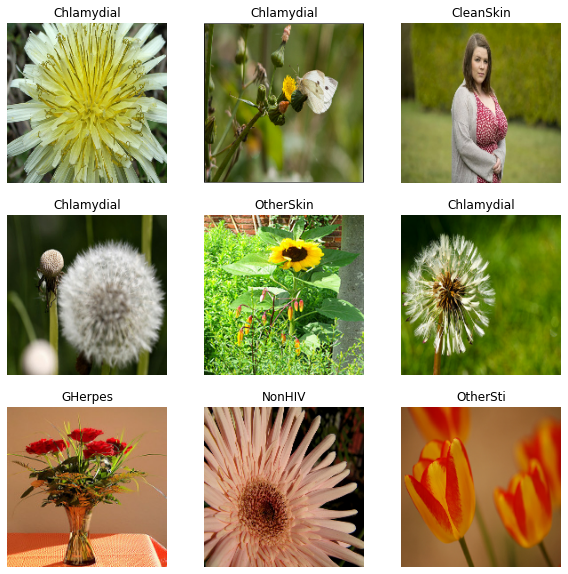

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


image_batch tensor corresponds to 32 images of 180px width, 180px height, and 3 colors.
label_batch tensor corresponds to labels of the 32 images.
numpy() can convert image_batch and labels_batch tensors to numpy.ndarray.

### Configure the dataset for performance.

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data.

- Convert color images into blank & white, to make them smaller for NN. 

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99028325


### Create a basic model.

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model is not very accurate, but it illustrates a standard approach.

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model.

Choose `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model.

In [17]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
99/99 [==============================] - 40s 394ms/step - loss: 1.5414 - accuracy: 0.4073 - val_loss: 1.1975 - val_accuracy: 0.5722
Epoch 2/100
99/99 [==============================] - 37s 374ms/step - loss: 1.1490 - accuracy: 0.5781 - val_loss: 1.0942 - val_accuracy: 0.5937
Epoch 3/100
99/99 [==============================] - 36s 366ms/step - loss: 0.9713 - accuracy: 0.6531 - val_loss: 1.0185 - val_accuracy: 0.6380
Epoch 4/100
99/99 [==============================] - 36s 366ms/step - loss: 0.7205 - accuracy: 0.7426 - val_loss: 1.1514 - val_accuracy: 0.6392
Epoch 5/100
99/99 [==============================] - 36s 366ms/step - loss: 0.5235 - accuracy: 0.8216 - val_loss: 1.2153 - val_accuracy: 0.6405
Epoch 6/100
99/99 [==============================] - 37s 373ms/step - loss: 0.2861 - accuracy: 0.9070 - val_loss: 1.4602 - val_accuracy: 0.6278
Epoch 7/100
99/99 [==============================] - 37s 374ms/step - loss: 0.1524 - accuracy: 0.9551 - val_loss: 1.6641 - val_accuracy:

99/99 [==============================] - 36s 365ms/step - loss: 7.4548e-04 - accuracy: 0.9997 - val_loss: 3.0023 - val_accuracy: 0.6608
Epoch 58/100
99/99 [==============================] - 36s 369ms/step - loss: 9.4636e-04 - accuracy: 0.9997 - val_loss: 3.0542 - val_accuracy: 0.6595
Epoch 59/100
99/99 [==============================] - 36s 367ms/step - loss: 7.9928e-04 - accuracy: 0.9994 - val_loss: 3.0764 - val_accuracy: 0.6582
Epoch 60/100
99/99 [==============================] - 36s 368ms/step - loss: 9.4631e-04 - accuracy: 0.9994 - val_loss: 3.0959 - val_accuracy: 0.6595
Epoch 61/100
99/99 [==============================] - 37s 371ms/step - loss: 8.2123e-04 - accuracy: 0.9997 - val_loss: 3.1206 - val_accuracy: 0.6633
Epoch 62/100
99/99 [==============================] - 37s 372ms/step - loss: 7.8505e-04 - accuracy: 0.9994 - val_loss: 3.1318 - val_accuracy: 0.6633
Epoch 63/100
99/99 [==============================] - 36s 369ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 3.15

### Visualize training results.

Create plots of the loss and accuracy on the training and validation sets.

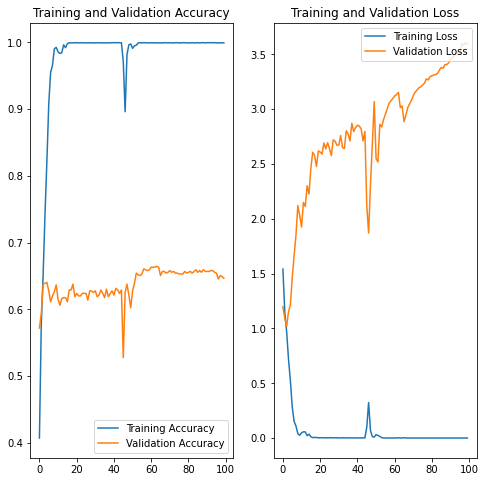

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

These plots indicate an overfitting, whereby the validation accuracy is very poor and much lower than the training accuracy. Data Augmentation and Dropout can be used for correcting this issue.

### Use data augmentation.

In [19]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)])

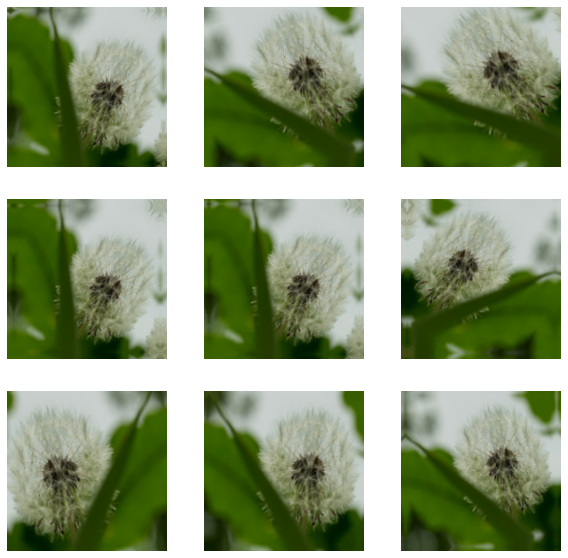

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Make a model with data augmentation and dropout.

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compile and train the model.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [24]:
epochs = 200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/200
99/99 [==============================] - 44s 439ms/step - loss: 1.5491 - accuracy: 0.4058 - val_loss: 1.3664 - val_accuracy: 0.4975
Epoch 2/200
99/99 [==============================] - 43s 436ms/step - loss: 1.2239 - accuracy: 0.5440 - val_loss: 1.1969 - val_accuracy: 0.5595
Epoch 3/200
99/99 [==============================] - 44s 441ms/step - loss: 1.1531 - accuracy: 0.5791 - val_loss: 1.0365 - val_accuracy: 0.6291
Epoch 4/200
99/99 [==============================] - 45s 452ms/step - loss: 1.0379 - accuracy: 0.6218 - val_loss: 0.9905 - val_accuracy: 0.6418
Epoch 5/200
99/99 [==============================] - 45s 451ms/step - loss: 0.9648 - accuracy: 0.6452 - val_loss: 0.9459 - val_accuracy: 0.6532
Epoch 6/200
99/99 [==============================] - 45s 451ms/step - loss: 0.9212 - accuracy: 0.6607 - val_loss: 0.9123 - val_accuracy: 0.6785
Epoch 7/200
99/99 [==============================] - 44s 449ms/step - loss: 0.8778 - accuracy: 0.6730 - val_loss: 0.8951 - val_accuracy:

99/99 [==============================] - 45s 454ms/step - loss: 0.1816 - accuracy: 0.9405 - val_loss: 1.3766 - val_accuracy: 0.7253
Epoch 58/200
99/99 [==============================] - 45s 452ms/step - loss: 0.1336 - accuracy: 0.9579 - val_loss: 1.3573 - val_accuracy: 0.7278
Epoch 59/200
99/99 [==============================] - 46s 460ms/step - loss: 0.1381 - accuracy: 0.9538 - val_loss: 1.4605 - val_accuracy: 0.7342
Epoch 60/200
99/99 [==============================] - 44s 446ms/step - loss: 0.1092 - accuracy: 0.9620 - val_loss: 1.4101 - val_accuracy: 0.7367
Epoch 61/200
99/99 [==============================] - 44s 441ms/step - loss: 0.0992 - accuracy: 0.9668 - val_loss: 1.4375 - val_accuracy: 0.7519
Epoch 62/200
99/99 [==============================] - 43s 437ms/step - loss: 0.0961 - accuracy: 0.9649 - val_loss: 1.5561 - val_accuracy: 0.7304
Epoch 63/200
99/99 [==============================] - 43s 438ms/step - loss: 0.1343 - accuracy: 0.9586 - val_loss: 1.6331 - val_accuracy: 0.732

99/99 [==============================] - 44s 442ms/step - loss: 0.0528 - accuracy: 0.9813 - val_loss: 1.8592 - val_accuracy: 0.7342
Epoch 114/200
99/99 [==============================] - 43s 432ms/step - loss: 0.0947 - accuracy: 0.9712 - val_loss: 1.8516 - val_accuracy: 0.7266
Epoch 115/200
99/99 [==============================] - 44s 447ms/step - loss: 0.0640 - accuracy: 0.9801 - val_loss: 1.6390 - val_accuracy: 0.7430
Epoch 116/200
99/99 [==============================] - 45s 451ms/step - loss: 0.0767 - accuracy: 0.9782 - val_loss: 1.9260 - val_accuracy: 0.7367
Epoch 117/200
99/99 [==============================] - 44s 441ms/step - loss: 0.0814 - accuracy: 0.9747 - val_loss: 1.9641 - val_accuracy: 0.7316
Epoch 118/200
99/99 [==============================] - 44s 448ms/step - loss: 0.0672 - accuracy: 0.9807 - val_loss: 1.8122 - val_accuracy: 0.7405
Epoch 119/200
99/99 [==============================] - 44s 444ms/step - loss: 0.0519 - accuracy: 0.9839 - val_loss: 1.9091 - val_accuracy:

99/99 [==============================] - 43s 437ms/step - loss: 0.0612 - accuracy: 0.9794 - val_loss: 2.4994 - val_accuracy: 0.7291
Epoch 170/200
99/99 [==============================] - 44s 443ms/step - loss: 0.0551 - accuracy: 0.9851 - val_loss: 2.1579 - val_accuracy: 0.7380
Epoch 171/200
99/99 [==============================] - 44s 444ms/step - loss: 0.0670 - accuracy: 0.9807 - val_loss: 2.2566 - val_accuracy: 0.7405
Epoch 172/200
99/99 [==============================] - 46s 465ms/step - loss: 0.0418 - accuracy: 0.9858 - val_loss: 2.1830 - val_accuracy: 0.7367
Epoch 173/200
99/99 [==============================] - 45s 456ms/step - loss: 0.0356 - accuracy: 0.9867 - val_loss: 2.3863 - val_accuracy: 0.7494
Epoch 174/200
99/99 [==============================] - 44s 445ms/step - loss: 0.0499 - accuracy: 0.9836 - val_loss: 2.5228 - val_accuracy: 0.7278
Epoch 175/200
99/99 [==============================] - 45s 454ms/step - loss: 0.0324 - accuracy: 0.9902 - val_loss: 2.3363 - val_accuracy:

### Visualize training results.

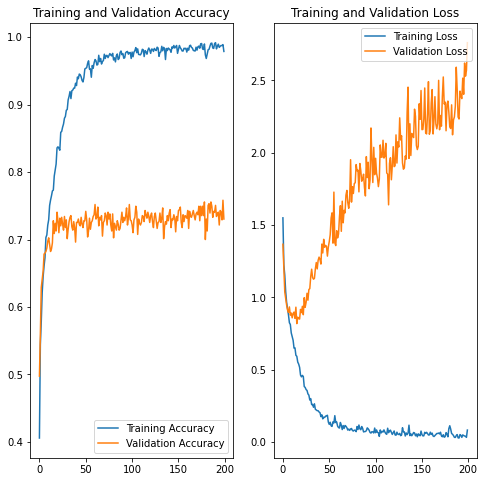

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data.

In [26]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to OtherSkin with a 100.00 percent confidence.


### Save the model for later use.

In [27]:
model.save('model.h5')

In [28]:
tf.saved_model.save(model, 'model')

INFO:tensorflow:Assets written to: model\assets


In [29]:
model_js = model.to_json()

In [30]:
import json
with open('model_js.json', 'w') as f:
    json.dump(model_js, f)

### Convert the model to a TensorFlow Lite model for mobile devices.

- https://www.tensorflow.org/lite/models/convert

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\A\AppData\Local\Temp\tmp1_vjexgu\assets


The TensorFlow Lite model you saved in the previous step can contain several function signatures (https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model.

In [32]:
interpreter = tf.lite.Interpreter(model_path = 'model.tflite')
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

This example has the default signature called `serving_default`. The names of the `'inputs'` and `'outputs'` are `'sequential_1_input'` and `'outputs'`.

In [33]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [34]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [35]:
print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite)))

This image most likely belongs to OtherSkin with a 100.00 percent confidence.


In [36]:
print(np.max(np.abs(predictions - predictions_lite)))

6.1035156e-05
